# Extension of Exploratory Data Analysis

In this section, we explore polarity, subjectivity and readability of customer reviews using different libraries and metrics. 

- The automated polarity patterns computed by NLP tools are re-scaled to get more appropiated results.
- Statistical tests are applied to verified the randomness of reviews according to scores, polarity patterns and readability, using the original biased dataset, unbiased resampled (using under and oversampling techniques). The conclusions by scenario are compared to discover how much sensitive are the results to changes in the dataset.

## Guideline

The main purposes here are the following:
### To Resolve the Predictive Score Modeling:
- Compare different polarity algorithms to determine which is the most appropiate in this scenario.
- Determine if we must calculate polarity scores per review or sentences into the reviews and then take the average or some percentile to estimate the polarity of the review.
- Determine if is useful to use more than one polarity algorithm as feature.
- Look for more potential language features (as lenght of the message, distribution of the polarity and subjectivity into the review, language stylish, readability, etc).

Importing relevant packages

In [1]:
import warnings

warnings.filterwarnings("ignore")

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import re

### a. TextBlob

Defining the **sentiment parameters pattern** function using one of the sentiment analyzer provides for *TextBlob*

In [2]:
from textblob.sentiments import PatternAnalyzer
from textblob import TextBlob

def sentiment_parameters_textblob(text_data):
    blob = TextBlob(text_data, analyzer=PatternAnalyzer())
    return blob.sentiment.polarity, blob.sentiment.subjectivity

In this case, we get a **polarity** and a **subjectivity score**.

### b. nltk Sentiment Intensity Analyzer

In [3]:
import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_nltk = SentimentIntensityAnalyzer()

def sentiment_parameters_nltk(text_data):
    return sentiment_nltk.polarity_scores(text_data)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daniela/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### c. FLAIR Sentiment Classifier

In [4]:
import sys
#!{sys.executable} -m pip install flair
import flair

flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

def sentiment_parameters_flair(text_data):
    s = flair.data.Sentence(text_data)
    flair_sentiment.predict(s)
    return s.labels

2020-06-18 16:06:59,008 loading file /Users/daniela/.flair/models/sentiment-en-mix-distillbert.pt


### Customer reviews dataset

In [5]:
df_reviews = pd.read_csv("../Data_Extraction/Reviews/reviews_rating_date.csv", \
                         usecols=['Coffee', 'Description','Rating', 'date'])

In [6]:
df_reviews.tail()

,Coffee,Description,Rating,date
3543,Red Door,Great atmosphere. Awesome coffee. One of my fa...,4.0 star rating,2/26/2018
3544,Red Door,This place was great- recommended to me by som...,4.0 star rating,2/5/2018
3545,Red Door,I really like the concept of this place - coff...,3.0 star rating,12/15/2017
3546,Red Door,"I love the artsy vibes in this cafe, because i...",4.0 star rating,10/29/2017
3547,Red Door,Really nice coffee shop within an art gallery....,5.0 star rating,10/17/2017


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 4 columns):
Coffee         3268 non-null object
Description    3548 non-null object
Rating         3548 non-null object
date           3548 non-null object
dtypes: object(4)
memory usage: 111.0+ KB


### Pre-processing steps

In [8]:
df_reviews['scores'] = df_reviews['Rating'].str.split(' star rating').str.get(0).astype(float)

In [9]:
df_reviews.drop(columns='Rating', inplace=True)

In [10]:
import datetime

def validate_date(date_str):
    try:
        date_updated = datetime.datetime.strptime(date_str.splitlines()[0], "%m/%d/%Y")
    except:
        print(date_str)
        raise ValueError("Incorrect data format, should be MM-DD-YYYY")
    return date_updated

In [11]:
df_reviews['valid_date'] =  df_reviews.date.apply(validate_date)

In [12]:
df_reviews.drop(columns='date', inplace=True)

In [13]:
df_reviews.Coffee[20:40] = 'Coffee 1'
df_reviews.Coffee[40:60] = 'Coffee 2'
df_reviews.Coffee[60:80] = 'The Mill'
df_reviews.Coffee[1939:1959] = 'The Mill 1'
df_reviews.Coffee[1200:1220] = 'Andytown Coffee 1'
df_reviews.Coffee[1691:1711] = 'Réveille Coffee 1'
df_reviews.Coffee[340:360] = 'Sightglass 1'
df_reviews.Coffee[780:800] = 'Sightglass 2'
df_reviews.Coffee[2439:2459] = 'Sightglass 3'
df_reviews.Coffee[940:960] = 'Saint Frank 2'
df_reviews.Coffee[800:820] = 'Philz 1'
df_reviews.Coffee[2739:2759] = 'Philz 2'
df_reviews.Coffee[3228:3248] = 'Philz 3'
df_reviews.Coffee[700:720] = 'Blue Bottle 1'
df_reviews.Coffee[2119:2139] = 'Blue Bottle 2'
df_reviews.Coffee[2499:2519] = 'Blue Bottle 3'
df_reviews.Coffee[2299:2319] = 'Jane on 1'
df_reviews.Coffee[2159:2179] = 'Equator Coffees & 1'
df_reviews.Coffee[2399:2419] = 'Equator Coffees & 2'
df_reviews.Coffee[3172:3192] = 'Contraband Coffee 1'
df_reviews.Coffee[2859:2879] = 'Little 1'
df_reviews.Coffee[1471:1491] = 'Cafe 1'
df_reviews.Coffee[2599:2619] = 'Cafe 2'
df_reviews.Coffee[2962:2982] = 'Cafe 3'
df_reviews.Coffee[3122:3132] = 'Bluestone 1'
df_reviews.Coffee[3528:3548] = 'Red Door 1'
df_reviews.Coffee[2339:2359] = 'Martha & Brothers 1'
df_reviews.Coffee[3042:3062] = 'Boba 1'
df_reviews.Coffee[3102:3122] = 'Boba 2'

In [14]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 4 columns):
Coffee         3308 non-null object
Description    3548 non-null object
scores         3548 non-null float64
valid_date     3548 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 111.0+ KB


### 1.1 Sentiment Analysis: Polarity and Subjectivity Patterns using TextBlob, NLTK and Flair:

In [15]:
df_reviews['polarity_textblob'] = [sentiment_parameters_textblob(r)[0] for r in df_reviews['Description']]

In [16]:
df_reviews['subjectivity_textblob'] = [sentiment_parameters_textblob(r)[1] for r in df_reviews['Description']]

In [17]:
df_reviews['neg_nltk'] = [sentiment_parameters_nltk(r)['neg'] for r in df_reviews['Description']]

In [18]:
df_reviews['neu_nltk'] = [sentiment_parameters_nltk(r)['neu'] for r in df_reviews['Description']]

In [19]:
df_reviews['pos_nltk'] = [sentiment_parameters_nltk(r)['pos'] for r in df_reviews['Description']]

In [20]:
df_reviews['compound_nltk'] = [sentiment_parameters_nltk(r)['compound'] for r in df_reviews['Description']]

In [21]:
df_reviews['value_flair'] = [sentiment_parameters_flair(r)[0].value for r in df_reviews['Description']]

In [22]:
df_reviews['score_flair'] = [sentiment_parameters_flair(r)[0].score for r in df_reviews['Description']]

In [23]:
df_reviews.head()

,Coffee,Description,scores,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,value_flair,score_flair
0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",4.0,2019-05-10,0.250758,0.692424,0.102,0.661,0.237,0.9308,POSITIVE,0.998546
1,Réveille Coffee,"I wanted to like this place, however the venti...",2.0,2019-04-20,0.051736,0.624306,0.075,0.826,0.099,0.1606,NEGATIVE,0.999996
2,Réveille Coffee,I didn't tried brunch before in another locati...,5.0,2019-04-18,0.666667,0.616667,0.000,0.655,0.345,0.9538,POSITIVE,0.997934
3,Réveille Coffee,"Folks, avoid this place unless you like being ...",1.0,2019-04-16,0.070000,0.607778,0.075,0.822,0.103,0.6261,NEGATIVE,0.999989
4,Réveille Coffee,A nice compact coffee shop at Castro area. Qua...,4.0,2019-04-16,0.390000,0.610000,0.000,0.647,0.353,0.8689,POSITIVE,0.968480


### 1.2 Readability tests applied to reviews

In this section, we use **textstat**, a Python package to calculate statistics from text to determine readability, complexity and grade level of a particular corpus. The scores give us information about how easy or difficult to understand are the reviews.

In [24]:
#!{sys.executable} -m pip install textstat

import textstat

In [25]:
def flesch(text_data):
    return textstat.flesch_reading_ease(text_data)

def kincaid_grade(text_data):
    return textstat.flesch_kincaid_grade(text_data)

def coleman_liau_index(text_data):
    return textstat.coleman_liau_index(text_data)

def ari(text_data):
    return textstat.automated_readability_index(text_data)

def dale_chall_readability(text_data):
    return textstat.dale_chall_readability_score(text_data)

def difficult_words(text_data):
    return textstat.difficult_words(text_data)

def text_standard(text_data):
    return textstat.text_standard(text_data)

In [26]:
df_reviews['flesch'] = [flesch(r) for r in df_reviews['Description']]

In [27]:
df_reviews['kincaid_grade'] = [kincaid_grade(r) for r in df_reviews['Description']]

In [28]:
df_reviews['coleman_liau_index'] = [coleman_liau_index(r) for r in df_reviews['Description']]

In [29]:
df_reviews['ari'] = [ari(r) for r in df_reviews['Description']]

In [30]:
df_reviews['dale_chall_readability'] = [dale_chall_readability(r) for r in df_reviews['Description']]

In [31]:
df_reviews['difficult_words'] = [difficult_words(r) for r in df_reviews['Description']]

In [32]:
df_reviews['text_standard'] = [text_standard(r) for r in df_reviews['Description']]

In [33]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 19 columns):
Coffee                    3308 non-null object
Description               3548 non-null object
scores                    3548 non-null float64
valid_date                3548 non-null datetime64[ns]
polarity_textblob         3548 non-null float64
subjectivity_textblob     3548 non-null float64
neg_nltk                  3548 non-null float64
neu_nltk                  3548 non-null float64
pos_nltk                  3548 non-null float64
compound_nltk             3548 non-null float64
value_flair               3548 non-null object
score_flair               3548 non-null float64
flesch                    3548 non-null float64
kincaid_grade             3548 non-null float64
coleman_liau_index        3548 non-null float64
ari                       3548 non-null float64
dale_chall_readability    3548 non-null float64
difficult_words           3548 non-null int64
text_standard             3

### 1.3 Sentiment Analysis by sentence

In [34]:
from collections import defaultdict  

d = defaultdict(list)

In [35]:
for i, review in enumerate(df_reviews.Description):
    for sentence in review.split('.')[:-1]:
        if len(sentence) > 1:
            d['id'].append(i)
            d['Coffee'].append(df_reviews.Coffee[i])
            d['description_sentence'].append(str(sentence))
            d['valid_date'].append(df_reviews.valid_date[i])
            d['score'].append(df_reviews.scores[i])

In [36]:
df_review_sentences = pd.DataFrame(data=d)

In [37]:
df_review_sentences.head(10)

,id,Coffee,description_sentence,valid_date,score
0,0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",2019-05-10,4.0
1,0,Réveille Coffee,The only downside to coming to this cafe is t...,2019-05-10,4.0
2,0,Réveille Coffee,"Other than that, nice and friendly environment",2019-05-10,4.0
3,0,Réveille Coffee,"Remember, no wifi on the weekends",2019-05-10,4.0
4,1,Réveille Coffee,"I wanted to like this place, however the venti...",2019-04-20,2.0
5,1,Réveille Coffee,"Not only that, I saw cleaning supplies left c...",2019-04-20,2.0
6,1,Réveille Coffee,Though the furniture is nice and the food is ...,2019-04-20,2.0
7,1,Réveille Coffee,My coffee tasted of bleach because of the smell,2019-04-20,2.0
8,1,Réveille Coffee,"By the end of my time drinking coffee here, m...",2019-04-20,2.0
9,1,Réveille Coffee,I wish I were not exaggerating because I real...,2019-04-20,2.0


In [38]:
df_review_sentences['polarity_textblob'] = [sentiment_parameters_textblob(s)[0] 
                                            for s in df_review_sentences['description_sentence']]

In [39]:
df_review_sentences['subjectivity_textblob'] = [sentiment_parameters_textblob(s)[1] 
                                                for s in df_review_sentences['description_sentence']]

In [40]:
df_review_sentences['neg_nltk'] = [sentiment_parameters_nltk(s)['neg'] 
                                   for s in df_review_sentences['description_sentence']]

In [41]:
df_review_sentences['neu_nltk'] = [sentiment_parameters_nltk(s)['neu'] 
                                   for s in df_review_sentences['description_sentence']]

In [42]:
df_review_sentences['pos_nltk'] = [sentiment_parameters_nltk(s)['pos'] 
                                   for s in df_review_sentences['description_sentence']]

In [43]:
df_review_sentences['compound_nltk'] = [sentiment_parameters_nltk(s)['compound'] 
                                        for s in df_review_sentences['description_sentence']]

In [44]:
df_review_sentences.head(5)

,id,Coffee,description_sentence,valid_date,score,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk
0,0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",2019-05-10,4.0,0.600000,0.783333,0.000,0.493,0.507,0.9062
1,0,Réveille Coffee,The only downside to coming to this cafe is t...,2019-05-10,4.0,-0.097917,0.722917,0.154,0.846,0.000,-0.6933
2,0,Réveille Coffee,"Other than that, nice and friendly environment",2019-05-10,4.0,0.283333,0.625000,0.000,0.455,0.545,0.7184
3,0,Réveille Coffee,"Remember, no wifi on the weekends",2019-05-10,4.0,0.000000,0.000000,0.306,0.694,0.000,-0.2960
4,1,Réveille Coffee,"I wanted to like this place, however the venti...",2019-04-20,2.0,-0.400000,0.600000,0.145,0.764,0.091,-0.3593


As we can detect, when we calculate the polarity of a review, we get an average score, considering the number of sentences of the review. If a sentence has 0 points (it means that the sentences is not positive or negative), this value disminish the effect of the positive or negative sentences and the whole review don't get an appropiate score. How can we resolve that? 

- Ignoring the sentences with scores around 0 (absolute value less than 0.1) in the polarity estimation (not in subjectivity).

In [120]:
df_Reviews = df_reviews.copy()

In [121]:
df = df_review_sentences[np.abs(df_review_sentences.polarity_textblob) > 0.1]
df_Reviews['polarity_textblob'] = df.groupby('id').polarity_textblob.mean()

In [122]:
df = df_review_sentences[df_review_sentences.neg_nltk > 0.1]
df_Reviews['neg_nltk'] = df.groupby('id').neg_nltk.mean()

In [123]:
df = df_review_sentences[df_review_sentences.pos_nltk > 0.1]
df_Reviews['pos_nltk'] = df.groupby('id').pos_nltk.mean()

In [124]:
df_Reviews.fillna(0, inplace=True)

In [125]:
df_Reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 19 columns):
Coffee                    3548 non-null object
Description               3548 non-null object
scores                    3548 non-null float64
valid_date                3548 non-null datetime64[ns]
polarity_textblob         3548 non-null float64
subjectivity_textblob     3548 non-null float64
neg_nltk                  3548 non-null float64
neu_nltk                  3548 non-null float64
pos_nltk                  3548 non-null float64
compound_nltk             3548 non-null float64
value_flair               3548 non-null object
score_flair               3548 non-null float64
flesch                    3548 non-null float64
kincaid_grade             3548 non-null float64
coleman_liau_index        3548 non-null float64
ari                       3548 non-null float64
dale_chall_readability    3548 non-null float64
difficult_words           3548 non-null int64
text_standard             3

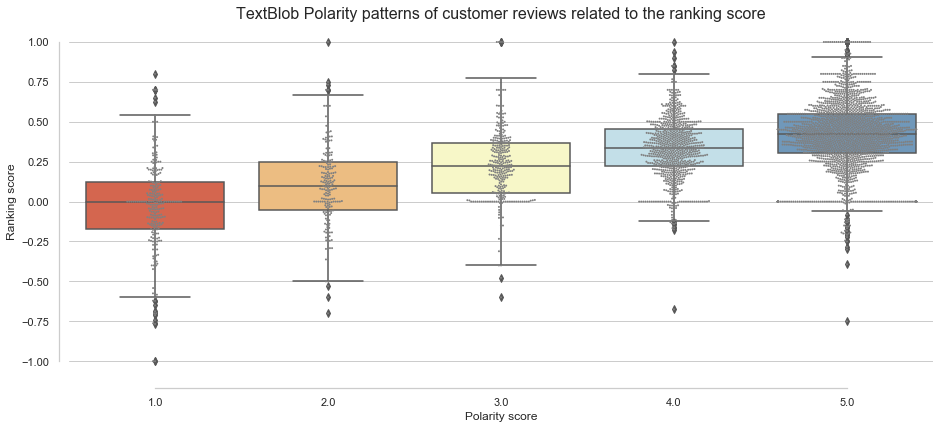

In [82]:
f, ax = plt.subplots(figsize=(15.5, 6.5))
_ = sns.set(style="whitegrid", palette="muted")
_ = sns.boxplot(x="scores", y="polarity_textblob", data=df_Reviews, palette="RdYlBu")
_ = sns.swarmplot(x="scores", y="polarity_textblob", data=df_Reviews, size=2, color=".5", linewidth=0)
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Polarity score', size=12)
_ = plt.ylabel('Ranking score', size=12)
_ = plt.title('TextBlob Polarity patterns of customer reviews related to the ranking score', size=16)

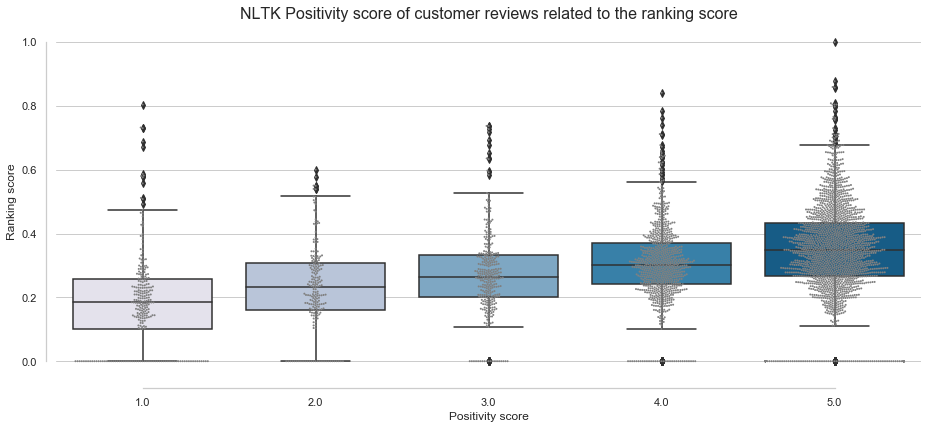

In [83]:
f, ax = plt.subplots(figsize=(15.5, 6.5))
_ = sns.set(style="whitegrid", palette="muted")
_ = sns.boxplot(x="scores", y="pos_nltk", data=df_Reviews, palette="PuBu")
_ = sns.swarmplot(x="scores", y="pos_nltk", data=df_Reviews, size=2, color=".5", linewidth=0)
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Positivity score', size=12)
_ = plt.ylabel('Ranking score', size=12)
_ = plt.title('NLTK Positivity score of customer reviews related to the ranking score', size=16)

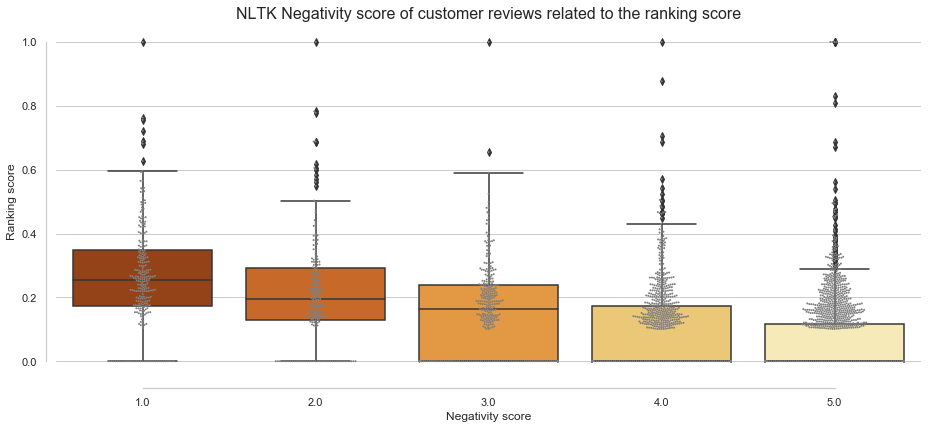

In [84]:
f, ax = plt.subplots(figsize=(15.5, 6.5))
_ = sns.set(style="whitegrid", palette="muted")
_ = sns.boxplot(x="scores", y="neg_nltk", data=df_Reviews, palette="YlOrBr_r")
_ = sns.swarmplot(x="scores", y="neg_nltk", data=df_Reviews, size=2, color=".5", linewidth=0)
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Negativity score', size=12)
_ = plt.ylabel('Ranking score', size=12)
_ = plt.title('NLTK Negativity score of customer reviews related to the ranking score', size=16)

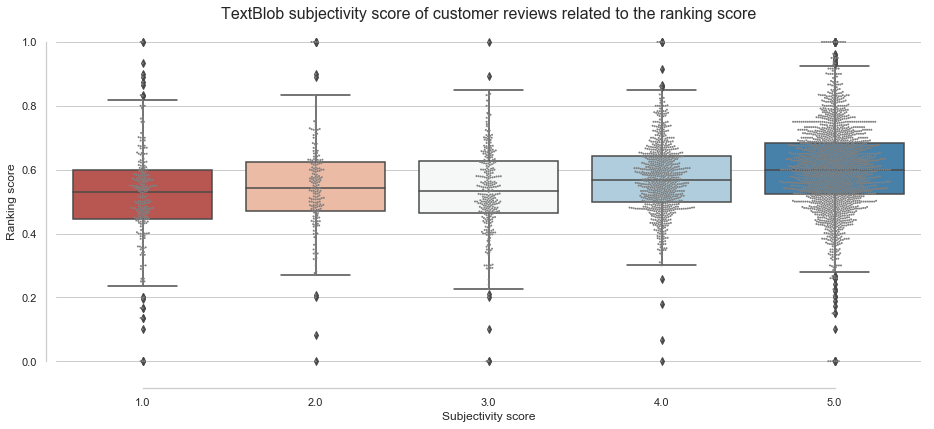

In [85]:
f, ax = plt.subplots(figsize=(15.5, 6.5))
_ = sns.set(style="whitegrid", palette="muted")
_ = sns.boxplot(x="scores", y="subjectivity_textblob", data=df_Reviews, palette="RdBu")
_ = sns.swarmplot(x="scores", y="subjectivity_textblob", data=df_Reviews, size=2, color=".5", linewidth=0)
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Subjectivity score', size=12)
_ = plt.ylabel('Ranking score', size=12)
_ = plt.title('TextBlob subjectivity score of customer reviews related to the ranking score', size=16)

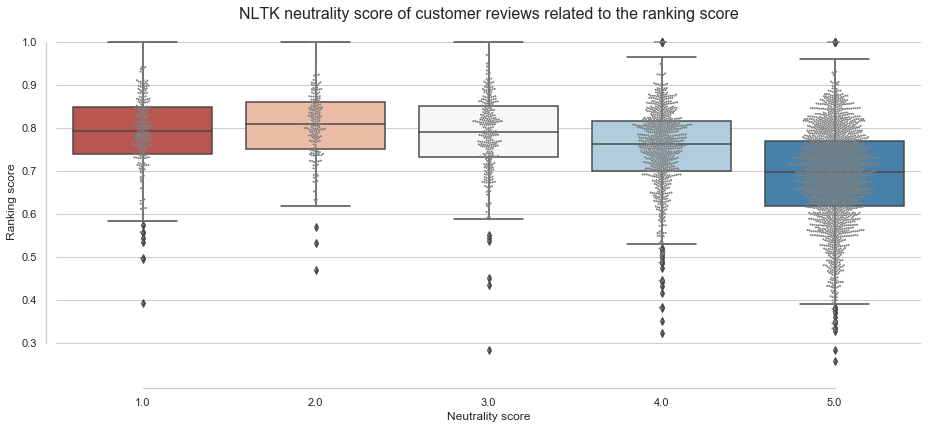

In [86]:
f, ax = plt.subplots(figsize=(15.5, 6.5))
_ = sns.set(style="whitegrid", palette="muted")
_ = sns.boxplot(x="scores", y="neu_nltk", data=df_Reviews, palette="RdBu")
_ = sns.swarmplot(x="scores", y="neu_nltk", data=df_Reviews, size=2, color=".5", linewidth=0)
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Neutrality score', size=12)
_ = plt.ylabel('Ranking score', size=12)
_ = plt.title('NLTK neutrality score of customer reviews related to the ranking score', size=16)

### 1.4 Interpreatibility of Flair Values

In [126]:
df_Reviews.groupby(['value_flair', 'scores']).count()

Coffee  Description  valid_date  polarity_textblob  \
value_flair scores                                                       
NEGATIVE    1.0        259          259         259                259   
            2.0        195          195         195                195   
            3.0        261          261         261                261   
            4.0        144          144         144                144   
            5.0         52           52          52                 52   
POSITIVE    1.0          4            4           4                  4   
            2.0         12           12          12                 12   
            3.0         66           66          66                 66   
            4.0        677          677         677                677   
            5.0       1878         1878        1878               1878   

                    subjectivity_textblob  neg_nltk  neu_nltk  pos_nltk  \
value_flair scores                                                        
NEGATIVE    1.0                       259       259       259       259   
            2.0                       195       195       195       195   
            3.0                       261       261       261       261   
            4.0                       144       144       144       144   
            5.0                        52        52        52        52   
POSITIVE    1.0                         4         4         4         4   
            2.0                        12        12        12        12   
            3.0                        66        66        66        66   
            4.0                       677       677       677       677   
            5.0                      1878      1878      1878      1878   

                    compound_nltk  score_flair  flesch  kincaid_grade  \
value_flair scores                                                      
NEGATIVE    1.0               259          259     259            259   
            2.0               195          195     195            195   
            3.0               261          261     261            261   
            4.0               144          144     144            144   
            5.0                52           52      52             52   
POSITIVE    1.0                 4            4       4              4   
            2.0                12           12      12             12   
            3.0                66           66      66             66   
            4.0               677          677     677            677   
            5.0              1878         1878    1878           1878   

                    coleman_liau_index   ari  dale_chall_readability  \
value_flair scores                                                     
NEGATIVE    1.0                    259   259                     259   
            2.0                    195   195                     195   
            3.0                    261   261                     261   
            4.0                    144   144                     144   
            5.0                     52    52                      52   
POSITIVE    1.0                      4     4                       4   
            2.0                     12    12                      12   
            3.0                     66    66                      66   
            4.0                    677   677                     677   
            5.0                   1878  1878                    1878   

                    difficult_words  text_standard  
value_flair scores                                  
NEGATIVE    1.0                 259            259  
            2.0                 195            195  
            3.0                 261            261  
            4.0                 144            144  
            5.0                  52             52  
POSITIVE    1.0                   4              4  
            2.0                  12             12  
           

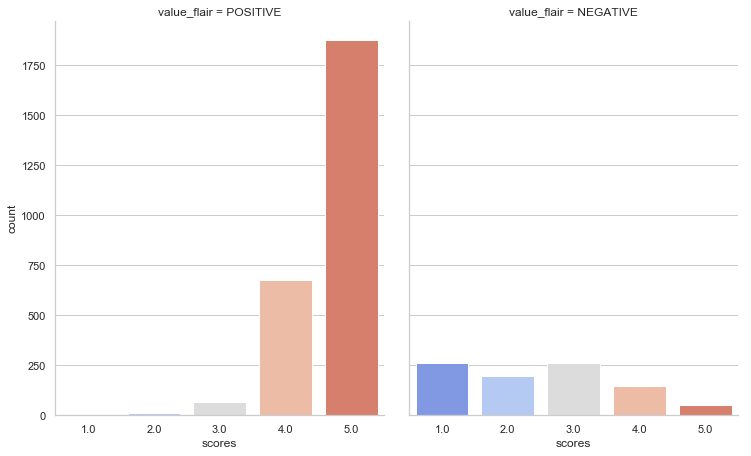

In [127]:
_ = sns.catplot("scores", col="value_flair", col_wrap=2,
                data=df_Reviews, kind="count", height=6.5, 
                aspect=.8, palette='coolwarm')

### 1.5 Randomness Test

1. Wald Wolfowitz Runs Test for sentiment scores
2. Wald Wolfowitz Runs Test for readability

In [128]:
df_RandomnTest = df_Reviews.copy()
# df_RandomnTest.drop(axis=1, columns=['Coffee', 'Description', 
#                                      'valid_date', 'text_standard',
#                                      'value_flair', 'score_flair'], inplace=True)

In [130]:
list_col = ['Coffee', 'Description', 'valid_date', 'text_standard', 'value_flair', 'score_flair']

In [131]:
for col in df_RandomnTest.columns:
    if col not in list_col:
        avg = df_RandomnTest[col].mean()
        df_RandomnTest['avg_'+ col] = df_RandomnTest[col].apply(lambda x: 1 if x >= avg else 0)

In [132]:
df_RandomnTest.head()

,Coffee,Description,scores,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,...,avg_neg_nltk,avg_neu_nltk,avg_pos_nltk,avg_compound_nltk,avg_flesch,avg_kincaid_grade,avg_coleman_liau_index,avg_ari,avg_dale_chall_readability,avg_difficult_words
0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",4.0,2019-05-10,0.441667,0.692424,0.23000,0.661,0.52600,0.9308,...,1,0,1,1,1,0,0,0,0,0
1,Réveille Coffee,"I wanted to like this place, however the venti...",2.0,2019-04-20,0.046042,0.624306,0.14075,0.826,0.15800,0.1606,...,1,1,0,0,0,1,0,0,1,1
2,Réveille Coffee,I didn't tried brunch before in another locati...,5.0,2019-04-18,0.500000,0.616667,0.00000,0.655,0.33950,0.9538,...,0,0,1,1,1,0,0,0,0,0
3,Réveille Coffee,"Folks, avoid this place unless you like being ...",1.0,2019-04-16,0.073611,0.607778,0.22800,0.822,0.26225,0.6261,...,1,1,0,0,0,1,1,1,0,1
4,Réveille Coffee,A nice compact coffee shop at Castro area. Qua...,4.0,2019-04-16,0.425000,0.610000,0.00000,0.647,0.35900,0.8689,...,0,0,1,1,1,0,1,0,1,0


In [133]:
df_RandomnTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 32 columns):
Coffee                        3548 non-null object
Description                   3548 non-null object
scores                        3548 non-null float64
valid_date                    3548 non-null datetime64[ns]
polarity_textblob             3548 non-null float64
subjectivity_textblob         3548 non-null float64
neg_nltk                      3548 non-null float64
neu_nltk                      3548 non-null float64
pos_nltk                      3548 non-null float64
compound_nltk                 3548 non-null float64
value_flair                   3548 non-null object
score_flair                   3548 non-null float64
flesch                        3548 non-null float64
kincaid_grade                 3548 non-null float64
coleman_liau_index            3548 non-null float64
ari                           3548 non-null float64
dale_chall_readability        3548 non-null float64
diffi

In [134]:
#!{sys.executable} -m pip install skidmarks

In [135]:
from skidmarks import wald_wolfowitz

**Wald Wolfowitz test** is a non-parametric statistical test that checks randomness of a two-valued sequence, establishing the following null and alternative hypothesis:
    
$$H0:  \text{The sequence was produced in a random manner}$$

$$Ha:  \text{The sequence was not produced in a random manner}$$

In other words, the **test checks if the elements of the sequence are mutually independent**. In text manipulation, this kind of tests are used to detect patterns in the sequences of texts, analyzing polarity, subjectivity, readability and customer evaluation. If reviews are written only by customers, the writing styles, ratings and polarity would be random due to the diverse background and experiences of the customers. Non-random results would indicate the existence of manipulation (*Manipulation of online reviews: An analysis of ratings, readability, and
sentiments*).

In the next projects, we'll do an in-deep analysis of manipulation patterns. For now, it's interesting to apply Wald Wolfowitz test to verify the randomness of data previous to use in predictive modeling and as part of this extension of the Exploratory Data Analysis.

For simplicity, the average of the variable is calculated and data in the right side of the average is labeled as 1 (otherwise, 0). With significance level of 0.05, we reject the null hypothesis if the p-value of the test is upper to 0.05 and we fail to reject the null hypothesis if the p-value is less than 0.05.

In [136]:
def wald_wolfowitz_report(sequence, significance_level, str_attribute):
    p_value = wald_wolfowitz(sequence)['p'] 
    if p_value < significance_level:
        print('Fail to reject the null hypothesis about randomness of the '+ str_attribute +' sequence.')
    else:
        print('Reject the null hypothesis about randomness of the '+ str_attribute +' sequence.')
    return p_value

In [137]:
print('WALF WOLFOWITZ REPORT \n-----------------------------------------------------------------')
for col in df_RandomnTest.iloc[:, 21:]:
    p_value = wald_wolfowitz_report(df_RandomnTest[col], 0.05, col)
    print('p_value = {}\n-----------------------------------------------------------------'.format(p_value)) 

WALF WOLFOWITZ REPORT 
-----------------------------------------------------------------
Reject the null hypothesis about randomness of the avg_subjectivity_textblob sequence.
p_value = 0.21408165644669636
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_neg_nltk sequence.
p_value = 8.536177472547371e-05
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_neu_nltk sequence.
p_value = 0.047722766162841844
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_pos_nltk sequence.
p_value = 0.022494162885609847
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_compound_nltk sequence.
p_value = 0.002211185623651663
-----------------------------------------------------------------
Reject

In [138]:
df_Reviews.groupby('scores').count()

,Coffee,Description,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,value_flair,score_flair,flesch,kincaid_grade,coleman_liau_index,ari,dale_chall_readability,difficult_words,text_standard
scores,,,,,,,,,,,,,,,,,,
1.0,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263
2.0,207,207,207,207,207,207,207,207,207,207,207,207,207,207,207,207,207,207
3.0,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327
4.0,821,821,821,821,821,821,821,821,821,821,821,821,821,821,821,821,821,821
5.0,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930,1930


In [139]:
df_ReviewsSample = df_RandomnTest.groupby('scores').apply(lambda x: x.sample(n=200, random_state=42)).reset_index(drop=True)

In [140]:
df_ReviewsSample.groupby('scores').count()

,Coffee,Description,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,value_flair,...,avg_neg_nltk,avg_neu_nltk,avg_pos_nltk,avg_compound_nltk,avg_flesch,avg_kincaid_grade,avg_coleman_liau_index,avg_ari,avg_dale_chall_readability,avg_difficult_words
scores,,,,,,,,,,,,,,,,,,,,,
1.0,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
2.0,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
3.0,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
4.0,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
5.0,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200


In [141]:
print('WALF WOLFOWITZ REPORT AFTER UNDERSAMPLING\n-----------------------------------------------------------------')
for col in df_ReviewsSample.iloc[:, 21:]:
    p_value = wald_wolfowitz_report(df_ReviewsSample[col], 0.05, col)
    print('p_value = {}\n-----------------------------------------------------------------'.format(p_value)) 

WALF WOLFOWITZ REPORT AFTER UNDERSAMPLING
-----------------------------------------------------------------
Reject the null hypothesis about randomness of the avg_subjectivity_textblob sequence.
p_value = 0.16654860042020014
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_neg_nltk sequence.
p_value = 1.0202182102225889e-11
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_neu_nltk sequence.
p_value = 0.0023255258950336645
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_pos_nltk sequence.
p_value = 0.0005963449160945804
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_compound_nltk sequence.
p_value = 5.377763618146921e-22
-------------------------------------------------

### What if we apply oversampling instead?

In [142]:
from imblearn.over_sampling import RandomOverSampler

sampling_strategy = {1.0: 1000, 2.0: 1000, 3.0: 1000}
y = df_RandomnTest.scores
X = df_RandomnTest.drop(columns=['scores'])

In [143]:
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = ros.fit_resample(X, y)

In [144]:
print('WALF WOLFOWITZ REPORT AFTER OVERSAMPLING\n-----------------------------------------------------------------')
for col in X_res.iloc[:, 21:]:
    p_value = wald_wolfowitz_report(X_res[col], 0.05, col)
    print('p_value = {}\n-----------------------------------------------------------------'.format(p_value)) 

WALF WOLFOWITZ REPORT AFTER OVERSAMPLING
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_neg_nltk sequence.
p_value = 4.671642806325038e-38
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_neu_nltk sequence.
p_value = 5.753580542725778e-12
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_pos_nltk sequence.
p_value = 1.5716807277787975e-11
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_compound_nltk sequence.
p_value = 1.045622792420812e-78
-----------------------------------------------------------------
Reject the null hypothesis about randomness of the avg_flesch sequence.
p_value = 0.13481705609856282
-----------------------------------------------------------------

### Validation of Readability scores

In this section, the limit scores of every readability index are defined to assert that all the indexes are in the appropiate ranges before to apply statistical tests to measure randomness in stylish, gramatical and complexity. 

**Flesh Reading Ease** is one of the most popular readability checker. This index measure the ratio of words to sentences and the ratio of syllables to words and is used by the US milotary for checking technical document readability. Easier texts compute higher scores, as we can check in the following table:

Flesch Score|School Level|Notes
-----|------------|-----
100+	|Up to Year 5| Extremely easy to read.
90–100	|Year 6	Very easy to read. | Easily understood by an average 11-year-old student.
80–90	|Year 7	Easy to read. | Conversational English for consumers.
70–80	|Year 8	| Fairly easy to read.
60–70	|Years 9-10	Plain English. | Easily understood by 13- to 15-year-old students.
50–60	|Years 11-13	| Fairly difficult to read.
30–50	|Undergraduate	| Difficult to read.
0–30	|Postgraduate	| Very difficult to read. Best understood by university graduates.


**A score of 60 is a good target for plain understandable English on this measure.**

**Flesh-Kincaid** is an extension of Flesch Reading Ease that return an intuitive and understandable metric in its own converting the readability score to the US school grade. A Flesch-Kincaid score of 7-8 (US 7th to 8th grade, UK year 8-9) corresponds roughly to a Flesch Reading Ease measure of 60.

**The automated readability index (ARI)** is a readability test for English texts, designed to gauge the understandability of a text. As a rough guide, US grade level 1 corresponds to ages 6–8. Reading level grade 8 corresponds to the typical reading level of a 14-year-old US child. Grade 12, the highest US secondary-school grade before college, corresponds to the reading level of a 17-year-old.

Unlike the other indices, the ARI, along with the Coleman–Liau, relies on a factor of characters per word, instead of the usual syllables per word. Although opinion varies on its accuracy as compared to the syllables/word and complex words indices, characters/word is often faster to calculate, as the number of characters is more readily and accurately counted by computer programs than syllables. In fact, this index was designed for real-time monitoring of readability on electric typewriters.

**The Dale–Chall readability** formula is a readability test that provides a numeric gauge of the comprehension difficulty that readers come upon when reading a text. It uses a list of 3000 words that groups of fourth-grade American students could reliably understand, considering any word not on that list to be difficult. The following table shows how to interpretate the results:

Dale–Chall Score| Notes|
-----| -----|
4.9 or lower | easily understood by an average 4th-grade student or lower
5.0–5.9 | easily understood by an average 5th or 6th-grade student
6.0–6.9 | easily understood by an average 7th or 8th-grade student
7.0–7.9 | easily understood by an average 9th or 10th-grade student
8.0–8.9 | easily understood by an average 11th or 12th-grade student
9.0–9.9 | easily understood by an average 13th to 15th-grade (college) student

In [145]:
readability_limits = {'flesch': [0, 100], 
                      'kincaid_grade': [0, 20],
                      'ari': [1, 14],
                      'dale_chall_readability': [0, 9.9]}

In [146]:
def filter_edge_values(s, lower, upper):
    if s > upper:
        s = upper
    elif s < lower:
        s = lower
    return s

In [147]:
for col in df_Reviews.columns:
    if col in list(readability_limits.keys()):
        df_Reviews[col+'_corrected'] = df_Reviews[col].apply(filter_edge_values, args=(readability_limits[col][0], readability_limits[col][1]))

In [148]:
df_Reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 23 columns):
Coffee                              3548 non-null object
Description                         3548 non-null object
scores                              3548 non-null float64
valid_date                          3548 non-null datetime64[ns]
polarity_textblob                   3548 non-null float64
subjectivity_textblob               3548 non-null float64
neg_nltk                            3548 non-null float64
neu_nltk                            3548 non-null float64
pos_nltk                            3548 non-null float64
compound_nltk                       3548 non-null float64
value_flair                         3548 non-null object
score_flair                         3548 non-null float64
flesch                              3548 non-null float64
kincaid_grade                       3548 non-null float64
coleman_liau_index                  3548 non-null float64
ari                

### Analysis of Distribution and correlations

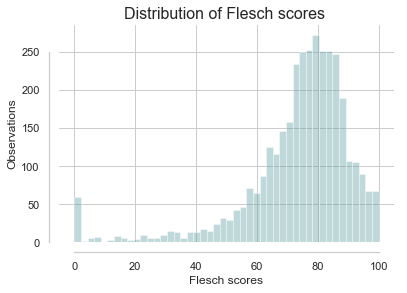

In [157]:
_ = sns.distplot(df_Reviews.flesch_corrected, kde=False, color='cadetblue')
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Flesch scores', size=12)
_ = plt.ylabel('Observations', size=12)
_ = plt.title('Distribution of Flesch scores ', size=16)

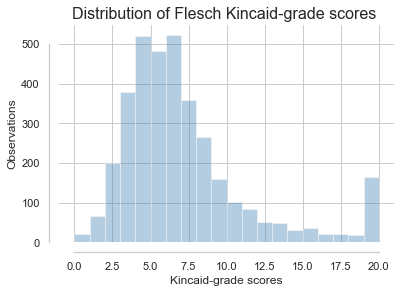

In [161]:
_ = sns.distplot(df_Reviews.kincaid_grade_corrected, bins=20, kde=False, color='steelblue')
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Kincaid-grade scores', size=12)
_ = plt.ylabel('Observations', size=12)
_ = plt.title('Distribution of Flesch Kincaid-grade scores ', size=16)

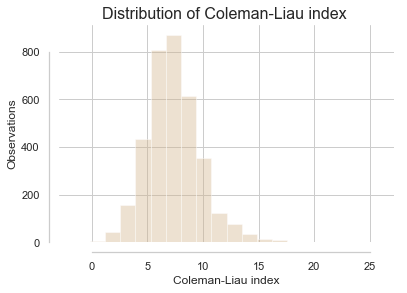

In [160]:
_ = sns.distplot(df_Reviews.coleman_liau_index, bins=20, kde=False, color='tan')
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Coleman-Liau index', size=12)
_ = plt.ylabel('Observations', size=12)
_ = plt.title('Distribution of Coleman-Liau index ', size=16)

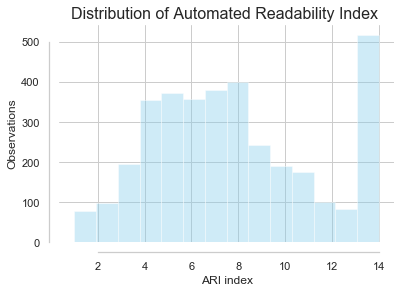

In [159]:
_ = sns.distplot(df_Reviews.ari_corrected, kde=False, bins=14, color='skyblue')
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('ARI index', size=12)
_ = plt.ylabel('Observations', size=12)
_ = plt.title('Distribution of Automated Readability Index', size=16)

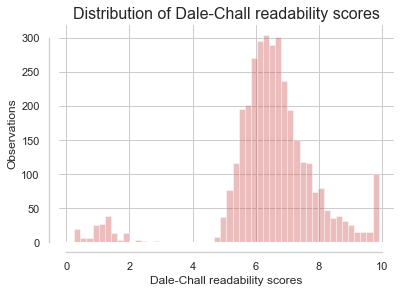

In [165]:
_ = sns.distplot(df_Reviews.dale_chall_readability_corrected, kde=False, color='indianred')
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Dale-Chall readability scores', size=12)
_ = plt.ylabel('Observations', size=12)
_ = plt.title('Distribution of Dale-Chall readability scores', size=16)

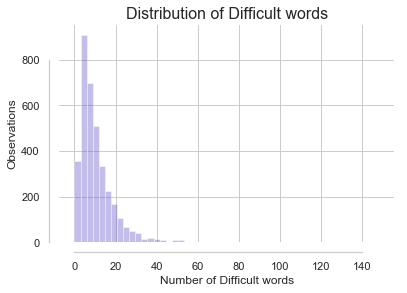

In [167]:
_ = sns.distplot(df_Reviews.difficult_words, kde=False, color='slateblue')
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Number of Difficult words', size=12)
_ = plt.ylabel('Observations', size=12)
_ = plt.title('Distribution of Difficult words', size=16)

### Number of words

In [289]:
df_Reviews['len_review'] = df_Reviews.Description.apply(len)

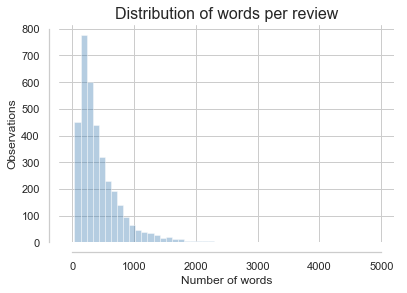

In [291]:
_ = sns.distplot(df_Reviews.len_review, kde=False, color='steelblue')
_ = sns.despine(offset=10, trim=True)
_ = plt.xlabel('Number of words', size=12)
_ = plt.ylabel('Observations', size=12)
_ = plt.title('Distribution of words per review', size=16)

In [307]:
df_Reviews.to_csv('../Machine_Learning/preprocessing_ml/polarity_readibility_features.csv', index=False)

### Data Mining 

In [210]:
df_mining = df_Reviews.copy()
df_mining.drop(columns=['flesch', 'kincaid_grade', 'ari', 'dale_chall_readability'], inplace=True)

In [211]:
df_mining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 19 columns):
Coffee                              3548 non-null object
Description                         3548 non-null object
scores                              3548 non-null float64
valid_date                          3548 non-null datetime64[ns]
polarity_textblob                   3548 non-null float64
subjectivity_textblob               3548 non-null float64
neg_nltk                            3548 non-null float64
neu_nltk                            3548 non-null float64
pos_nltk                            3548 non-null float64
compound_nltk                       3548 non-null float64
value_flair                         3548 non-null object
score_flair                         3548 non-null float64
coleman_liau_index                  3548 non-null float64
difficult_words                     3548 non-null int64
text_standard                       3548 non-null object
flesch_corrected      

In [213]:
def triScores(score):
    if score > 3:
        return 1
    elif score < 3:
        return -1
    else:
        return 0

In [217]:
df_mining['target'] = df_mining.scores.apply(triScores)

In [218]:
df_mining.groupby('target').count()

,Coffee,Description,scores,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,value_flair,score_flair,coleman_liau_index,difficult_words,text_standard,flesch_corrected,kincaid_grade_corrected,ari_corrected,dale_chall_readability_corrected
target,,,,,,,,,,,,,,,,,,,
-1,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470
0,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327,327
1,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751,2751


In [219]:
df_mining_sample = df_mining.groupby('target').apply(lambda x: x.sample(n=325, random_state=42)).reset_index(drop=True)

In [282]:
y = df_mining_sample.target
X = df_mining_sample.drop(columns=['scores', 'target', 'Coffee','Description', 'valid_date', 'text_standard', 'value_flair'])

In [285]:
X.columns

Index(['polarity_textblob', 'subjectivity_textblob', 'neg_nltk', 'neu_nltk',
       'pos_nltk', 'compound_nltk', 'score_flair', 'coleman_liau_index',
       'difficult_words', 'flesch_corrected', 'kincaid_grade_corrected',
       'ari_corrected', 'dale_chall_readability_corrected'],
      dtype='object')

In [287]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 12 best features
bestfeatures = SelectKBest(f_classif, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat dataFrames
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(13,'Score'))  #print all features

                               Specs       Score
5                      compound_nltk  223.367650
0                  polarity_textblob  171.801696
2                           neg_nltk  137.641978
3                           neu_nltk  103.331928
4                           pos_nltk   60.415035
6                        score_flair   25.165678
1              subjectivity_textblob   25.111055
10           kincaid_grade_corrected    6.180237
7                 coleman_liau_index    5.591446
8                    difficult_words    5.565207
11                     ari_corrected    3.667115
12  dale_chall_readability_corrected    1.427258
9                   flesch_corrected    1.307684


In [234]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [235]:
y_pred = clf.predict(X_test)

In [236]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, y_pred)

array([[70, 25,  1],
       [30, 50, 26],
       [ 5, 19, 67]])

In [237]:
accuracy_score(y_test, y_pred)

0.6382252559726962

In [238]:
from xgboost import XGBClassifier

In [249]:
#Inspecting performance adding estimators:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      objective='multi:softprob', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=1)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["merror"]
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.284457	validation_1-merror:0.375427
[1]	validation_0-merror:0.284457	validation_1-merror:0.389078
[2]	validation_0-merror:0.278592	validation_1-merror:0.392491
[3]	validation_0-merror:0.281525	validation_1-merror:0.399317
[4]	validation_0-merror:0.278592	validation_1-merror:0.389078
[5]	validation_0-merror:0.269795	validation_1-merror:0.389078
[6]	validation_0-merror:0.269795	validation_1-merror:0.382253
[7]	validation_0-merror:0.268328	validation_1-merror:0.389078
[8]	validation_0-merror:0.269795	validation_1-merror:0.389078
[9]	validation_0-merror:0.271261	validation_1-merror:0.389078
[10]	validation_0-merror:0.272727	validation_1-merror:0.385666
[11]	validation_0-merror:0.269795	validation_1-merror:0.385666
[12]	validation_0-merror:0.268328	validation_1-merror:0.389078
[13]	validation_0-merror:0.268328	validation_1-merror:0.389078
[14]	validation_0-merror:0.271261	validation_1-merror:0.392491
[15]	validation_0-merror:0.271261	validation_1-merror:0.389078
[1

[130]	validation_0-merror:0.244868	validation_1-merror:0.365188
[131]	validation_0-merror:0.244868	validation_1-merror:0.365188
[132]	validation_0-merror:0.246334	validation_1-merror:0.365188
[133]	validation_0-merror:0.244868	validation_1-merror:0.365188
[134]	validation_0-merror:0.243402	validation_1-merror:0.365188
[135]	validation_0-merror:0.241935	validation_1-merror:0.365188
[136]	validation_0-merror:0.241935	validation_1-merror:0.361775
[137]	validation_0-merror:0.240469	validation_1-merror:0.361775
[138]	validation_0-merror:0.239003	validation_1-merror:0.358362
[139]	validation_0-merror:0.240469	validation_1-merror:0.358362
[140]	validation_0-merror:0.240469	validation_1-merror:0.361775
[141]	validation_0-merror:0.237537	validation_1-merror:0.358362
[142]	validation_0-merror:0.237537	validation_1-merror:0.361775
[143]	validation_0-merror:0.234604	validation_1-merror:0.361775
[144]	validation_0-merror:0.234604	validation_1-merror:0.361775
[145]	validation_0-merror:0.234604	valid

[259]	validation_0-merror:0.214076	validation_1-merror:0.337884
[260]	validation_0-merror:0.214076	validation_1-merror:0.337884
[261]	validation_0-merror:0.214076	validation_1-merror:0.337884
[262]	validation_0-merror:0.214076	validation_1-merror:0.337884
[263]	validation_0-merror:0.214076	validation_1-merror:0.337884
[264]	validation_0-merror:0.214076	validation_1-merror:0.337884
[265]	validation_0-merror:0.214076	validation_1-merror:0.337884
[266]	validation_0-merror:0.21261	validation_1-merror:0.337884
[267]	validation_0-merror:0.21261	validation_1-merror:0.337884
[268]	validation_0-merror:0.21261	validation_1-merror:0.337884
[269]	validation_0-merror:0.21261	validation_1-merror:0.337884
[270]	validation_0-merror:0.21261	validation_1-merror:0.337884
[271]	validation_0-merror:0.21261	validation_1-merror:0.337884
[272]	validation_0-merror:0.211144	validation_1-merror:0.337884
[273]	validation_0-merror:0.206745	validation_1-merror:0.341297
[274]	validation_0-merror:0.206745	validation_

[388]	validation_0-merror:0.184751	validation_1-merror:0.351536
[389]	validation_0-merror:0.184751	validation_1-merror:0.351536
[390]	validation_0-merror:0.184751	validation_1-merror:0.351536
[391]	validation_0-merror:0.184751	validation_1-merror:0.351536
[392]	validation_0-merror:0.184751	validation_1-merror:0.351536
[393]	validation_0-merror:0.184751	validation_1-merror:0.351536
[394]	validation_0-merror:0.183284	validation_1-merror:0.354949
[395]	validation_0-merror:0.183284	validation_1-merror:0.354949
[396]	validation_0-merror:0.183284	validation_1-merror:0.354949
[397]	validation_0-merror:0.183284	validation_1-merror:0.358362
[398]	validation_0-merror:0.183284	validation_1-merror:0.358362
[399]	validation_0-merror:0.183284	validation_1-merror:0.358362
[400]	validation_0-merror:0.183284	validation_1-merror:0.354949
[401]	validation_0-merror:0.183284	validation_1-merror:0.354949
[402]	validation_0-merror:0.183284	validation_1-merror:0.354949
[403]	validation_0-merror:0.183284	valid

[517]	validation_0-merror:0.159824	validation_1-merror:0.372014
[518]	validation_0-merror:0.159824	validation_1-merror:0.368601
[519]	validation_0-merror:0.158358	validation_1-merror:0.368601
[520]	validation_0-merror:0.159824	validation_1-merror:0.372014
[521]	validation_0-merror:0.159824	validation_1-merror:0.372014
[522]	validation_0-merror:0.155425	validation_1-merror:0.372014
[523]	validation_0-merror:0.155425	validation_1-merror:0.372014
[524]	validation_0-merror:0.155425	validation_1-merror:0.372014
[525]	validation_0-merror:0.155425	validation_1-merror:0.375427
[526]	validation_0-merror:0.155425	validation_1-merror:0.375427
[527]	validation_0-merror:0.155425	validation_1-merror:0.375427
[528]	validation_0-merror:0.153959	validation_1-merror:0.375427
[529]	validation_0-merror:0.153959	validation_1-merror:0.375427
[530]	validation_0-merror:0.152493	validation_1-merror:0.375427
[531]	validation_0-merror:0.152493	validation_1-merror:0.375427
[532]	validation_0-merror:0.152493	valid

[646]	validation_0-merror:0.140762	validation_1-merror:0.37884
[647]	validation_0-merror:0.140762	validation_1-merror:0.37884
[648]	validation_0-merror:0.140762	validation_1-merror:0.37884
[649]	validation_0-merror:0.140762	validation_1-merror:0.37884
[650]	validation_0-merror:0.139296	validation_1-merror:0.37884
[651]	validation_0-merror:0.139296	validation_1-merror:0.37884
[652]	validation_0-merror:0.13783	validation_1-merror:0.37884
[653]	validation_0-merror:0.13783	validation_1-merror:0.37884
[654]	validation_0-merror:0.13783	validation_1-merror:0.37884
[655]	validation_0-merror:0.13783	validation_1-merror:0.37884
[656]	validation_0-merror:0.13783	validation_1-merror:0.37884
[657]	validation_0-merror:0.13783	validation_1-merror:0.37884
[658]	validation_0-merror:0.13783	validation_1-merror:0.37884
[659]	validation_0-merror:0.13783	validation_1-merror:0.37884
[660]	validation_0-merror:0.13783	validation_1-merror:0.37884
[661]	validation_0-merror:0.13783	validation_1-merror:0.37884
[6

[776]	validation_0-merror:0.121701	validation_1-merror:0.382253
[777]	validation_0-merror:0.118768	validation_1-merror:0.382253
[778]	validation_0-merror:0.118768	validation_1-merror:0.382253
[779]	validation_0-merror:0.118768	validation_1-merror:0.382253
[780]	validation_0-merror:0.118768	validation_1-merror:0.382253
[781]	validation_0-merror:0.120235	validation_1-merror:0.382253
[782]	validation_0-merror:0.118768	validation_1-merror:0.382253
[783]	validation_0-merror:0.118768	validation_1-merror:0.382253
[784]	validation_0-merror:0.118768	validation_1-merror:0.382253
[785]	validation_0-merror:0.118768	validation_1-merror:0.382253
[786]	validation_0-merror:0.118768	validation_1-merror:0.382253
[787]	validation_0-merror:0.118768	validation_1-merror:0.382253
[788]	validation_0-merror:0.118768	validation_1-merror:0.382253
[789]	validation_0-merror:0.118768	validation_1-merror:0.382253
[790]	validation_0-merror:0.118768	validation_1-merror:0.382253
[791]	validation_0-merror:0.118768	valid

[905]	validation_0-merror:0.111437	validation_1-merror:0.385666
[906]	validation_0-merror:0.111437	validation_1-merror:0.385666
[907]	validation_0-merror:0.111437	validation_1-merror:0.385666
[908]	validation_0-merror:0.111437	validation_1-merror:0.385666
[909]	validation_0-merror:0.111437	validation_1-merror:0.385666
[910]	validation_0-merror:0.111437	validation_1-merror:0.385666
[911]	validation_0-merror:0.111437	validation_1-merror:0.385666
[912]	validation_0-merror:0.111437	validation_1-merror:0.385666
[913]	validation_0-merror:0.111437	validation_1-merror:0.385666
[914]	validation_0-merror:0.111437	validation_1-merror:0.385666
[915]	validation_0-merror:0.111437	validation_1-merror:0.385666
[916]	validation_0-merror:0.111437	validation_1-merror:0.385666
[917]	validation_0-merror:0.111437	validation_1-merror:0.385666
[918]	validation_0-merror:0.111437	validation_1-merror:0.385666
[919]	validation_0-merror:0.111437	validation_1-merror:0.385666
[920]	validation_0-merror:0.111437	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.9, verbosity=1)

In [250]:
xg = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      objective='multi:softprob', 
                      n_estimators=260, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=1)

In [251]:
xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=260, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.9, verbosity=1)

In [252]:
y_pred = xg.predict(X_test)
predictions = [round(value) for value in y_pred]

In [253]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.21%


### Over-Sampling

In [275]:
ros = RandomOverSampler(sampling_strategy={-1:1000, 0:1000, 1:1000}, random_state=42)
X_res, y_res = ros.fit_resample(X, y)

In [276]:
X_trainres, X_testres, y_trainres, y_testres = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [277]:
#Inspecting performance adding estimators:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      objective='multi:softprob', 
                      n_estimators=200, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=1)

eval_set = [(X_trainres, y_trainres), (X_testres, y_testres)]
eval_metric = ["merror"]
%time model.fit(X_trainres, y_trainres, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.202857	validation_1-merror:0.293333
[1]	validation_0-merror:0.181429	validation_1-merror:0.273333
[2]	validation_0-merror:0.171905	validation_1-merror:0.257778
[3]	validation_0-merror:0.181429	validation_1-merror:0.266667
[4]	validation_0-merror:0.174762	validation_1-merror:0.261111
[5]	validation_0-merror:0.172381	validation_1-merror:0.263333
[6]	validation_0-merror:0.169048	validation_1-merror:0.257778
[7]	validation_0-merror:0.167619	validation_1-merror:0.247778
[8]	validation_0-merror:0.172381	validation_1-merror:0.247778
[9]	validation_0-merror:0.165714	validation_1-merror:0.245556
[10]	validation_0-merror:0.168571	validation_1-merror:0.25
[11]	validation_0-merror:0.169524	validation_1-merror:0.248889
[12]	validation_0-merror:0.166667	validation_1-merror:0.241111
[13]	validation_0-merror:0.158571	validation_1-merror:0.238889
[14]	validation_0-merror:0.158095	validation_1-merror:0.241111
[15]	validation_0-merror:0.158095	validation_1-merror:0.238889
[16]	v

[131]	validation_0-merror:0.120476	validation_1-merror:0.211111
[132]	validation_0-merror:0.120476	validation_1-merror:0.211111
[133]	validation_0-merror:0.119048	validation_1-merror:0.21
[134]	validation_0-merror:0.119524	validation_1-merror:0.21
[135]	validation_0-merror:0.119524	validation_1-merror:0.21
[136]	validation_0-merror:0.120952	validation_1-merror:0.214444
[137]	validation_0-merror:0.120952	validation_1-merror:0.212222
[138]	validation_0-merror:0.120952	validation_1-merror:0.214444
[139]	validation_0-merror:0.119524	validation_1-merror:0.213333
[140]	validation_0-merror:0.119524	validation_1-merror:0.212222
[141]	validation_0-merror:0.120476	validation_1-merror:0.213333
[142]	validation_0-merror:0.120476	validation_1-merror:0.213333
[143]	validation_0-merror:0.119048	validation_1-merror:0.212222
[144]	validation_0-merror:0.119048	validation_1-merror:0.212222
[145]	validation_0-merror:0.119048	validation_1-merror:0.212222
[146]	validation_0-merror:0.119048	validation_1-merr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.9, verbosity=1)

In [278]:
xgb_model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      objective='multi:softprob', 
                      n_estimators=180, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=1)

xg.fit(X_trainres, y_trainres)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=260, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.9, verbosity=1)

In [279]:
y_pred = xg.predict(X_testres)
predictions = [round(value) for value in y_pred]

In [280]:
accuracy = accuracy_score(y_testres, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.67%


In [288]:
#TO DO: incorporate len(message), number of syllables, number of words and number of complex structures (PoS)